# AutoRegressive Integrated Moving Average Model (ARIMA)

## Forecasting NYC Car Accidents

In [35]:
import pandas as pd
import numpy as np
import pmdarima as pm
from IPython.display import display, HTML

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
rcParams['figure.figsize'] = 16, 10
%matplotlib inline
import matplotlib as mpl

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime as dt

import warnings

The data was received from nycdata.gov using the SODA API. The data was aggregated by month from 2013 to 2020. We suspect that COVID-19 has reduced the total amount of car accidents, and this is obvious, however we want to project exactly how many accidents it was reduced by per month. 

First each month is plotted and then we remove the months that were affected by COVID to create a better model.

In [ ]:
#Acquired data from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

#df = pd.read_json('https://data.cityofnewyork.us/resource/h9gi-nx95.json?' +\
#             '$where=crash_date>"2011-12-31T00:00:00.000"' +\
#             '&$limit=2000000').replace(' ', '%20')

#df.crash_date = pd.to_datetime(df.crash_date)
#df = df['crash_date'].groupby(df.crash_date.dt.to_period("M")).agg('count')
#print(df)

In [57]:
df = pd.read_csv("https://raw.githubusercontent.com/willoutcault/NYC_Accidents_ARIMA_Forcast/master/Accidents.csv")
df['Month'] = pd.to_datetime(df['Month'], infer_datetime_format=True)
df = df.set_index(['Month'])

warnings.filterwarnings('ignore')
indexedDataset = df[0:91]

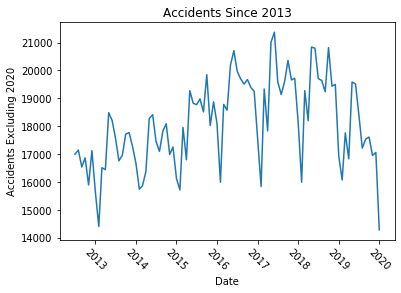

In [58]:
plt.xlabel("Date")
plt.ylabel("Accidents Excluding 2020")
plt.title("Accidents Since 2013")
plt.xticks(rotation=-45)
plt.plot(indexedDataset)

# Testing Stationarity 

In [59]:
def test_stationarity(timeseries):
    movingAverage = timeseries.rolling(window=12).mean()
    movingStd = timeseries.rolling(window=12).std()
    
    orig = plt.plot(timeseries, color='darkgreen', label='Original')
    mean = plt.plot(movingAverage, color='blue', label='Rolling Mean')
    std = plt.plot(movingStd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Accidents'], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

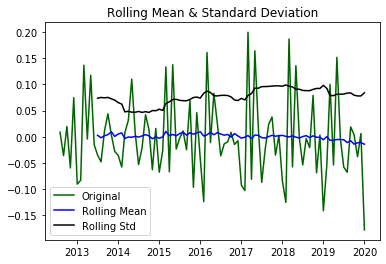

Results of Dickey-Fuller Test:
Test Statistic                 -1.086181
p-value                         0.720551
#Lags Used                     12.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [60]:
# Getting Log Value
indexedDataset_logScale = np.log(indexedDataset)
# Subtracting Rolling Average And STD
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingStd = indexedDataset_logScale.rolling(window=12).std()
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
# Time-Shift The Data (1 Degree)
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift(1)
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [61]:
%%capture
# Optimizing Parameters (p,q,m)
smodel = pm.auto_arima(indexedDataset_logScale['Accidents'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True);


In [62]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   91
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 150.893
Date:                            Wed, 13 May 2020   AIC                           -293.787
Time:                                    16:06:22   BIC                           -284.360
Sample:                                         0   HQIC                          -290.013
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0019      0.001     -2.387      0.017      -0.003      -0.000
ma.L1         -0.6125      0.103     -5.919      0.000      -0.815      -0.410
ma.S.L12      -0.6724      0.112     -5.982      0.000      -0.893      -0.452
sigma2         0.0011      0.000      5.957      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       22.19   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.99   Prob(JB):                         0.91
Heteroskedasticity (H):               0.61   Skew:                            -0.12
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

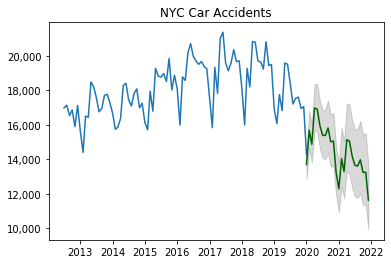

In [70]:
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexedDataset_logScale.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig, ax = plt.subplots()
plt.plot(np.exp(indexedDataset_logScale))
plt.plot(np.exp(fitted_series), color='darkgreen')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.fill_between(lower_series.index, 
                 np.exp(lower_series), 
                 np.exp(upper_series), 
                 color='k', alpha=.15)

plt.title("NYC Car Accidents")
plt.show()

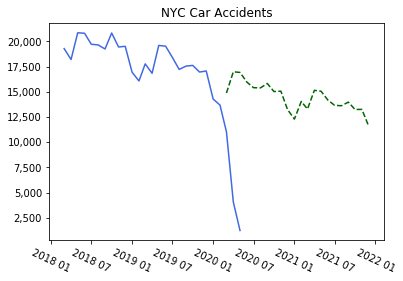

In [115]:
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(indexedDataset_logScale.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig, ax = plt.subplots()
plt.plot(df[68:], color='royalblue', label = 'Actual')
plt.plot(np.exp(fitted_series[2:]), color='darkgreen', linestyle='dashed', label = 'Projected')
monthyearFmt = mdates.DateFormatter('%Y %m')
ax.xaxis.set_major_formatter(monthyearFmt)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=-25)

plt.title("NYC Car Accidents")
plt.show()

In [154]:
#fitted_series = np.exp(fitted_series)
from ipywidgets import *
dt = pd.DataFrame({"Month":df.index[90:94], "Projections":fitted_series.values[0:4],
                   "Actual":df.values[90:94,0], "Percent Change":(100*fitted_series.values[0:4]-df.values[90:94,0])/fitted_series.values[0:4]})
dt

,Month,Projections,Actual,Percent Change
0,2020-01-01,13699.027101,14276,98.957882
1,2020-02-01,15679.855561,13671,99.128117
2,2020-03-01,14871.419626,11021,99.258914
3,2020-04-01,16976.652184,4059,99.760907
